In [2]:
import sys
sys.path.append("../src")
import pandas as pd
import ann_model as ann
import numpy as np
from ase.data import atomic_numbers
from matplotlib import pyplot as plt
elements = list(atomic_numbers.keys())

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_pickle("../data/all_data.xz")

In [3]:
dfx = df.drop(columns = ['time_per_call', 'n_calls', 'normalized_time_per_call', 'convergence'] + elements).astype('float')
dfy = df['normalized_time_per_call'].astype('float')

model = ann.TimePerCall(nvars = len(dfx.columns))
ind_tr, ind_val = ann.train_test_indices(dfx)
X_tr = dfx.loc[ind_tr]
Y_tr = dfy.loc[ind_tr]
X_val = dfx.loc[ind_val]
Y_val = dfy.loc[ind_val]
model.train_normed(X_tr, Y_tr)

Epoch 1/25
857/857 [==============================] - 2s 2ms/step - loss: 0.6373 - mae: 0.6273 - val_loss: 0.3905 - val_mae: 0.3803
Epoch 2/25
857/857 [==============================] - 2s 2ms/step - loss: 0.3042 - mae: 0.2939 - val_loss: 0.2184 - val_mae: 0.2081
Epoch 3/25
857/857 [==============================] - 2s 2ms/step - loss: 0.2416 - mae: 0.2312 - val_loss: 0.1802 - val_mae: 0.1699
Epoch 4/25
857/857 [==============================] - 2s 2ms/step - loss: 0.2153 - mae: 0.2050 - val_loss: 0.1590 - val_mae: 0.1487
Epoch 5/25
857/857 [==============================] - 2s 2ms/step - loss: 0.1980 - mae: 0.1877 - val_loss: 0.1429 - val_mae: 0.1327
Epoch 6/25
857/857 [==============================] - 2s 2ms/step - loss: 0.1877 - mae: 0.1774 - val_loss: 0.1322 - val_mae: 0.1219
Epoch 7/25
857/857 [==============================] - 2s 2ms/step - loss: 0.1787 - mae: 0.1685 - val_loss: 0.1285 - val_mae: 0.1183
Epoch 8/25
857/857 [==============================] - 2s 2ms/step - loss: 0.

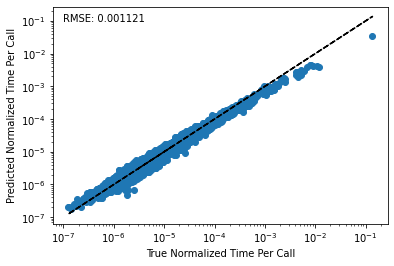

In [4]:
Y_hat = model.predict_normed(X_val)
plt.scatter(Y_val, Y_hat)
plt.plot(Y_val, Y_val, 'k--')
target = 'Normalized Time Per Call'
rmse = np.mean((Y_val.values - Y_hat[:, 0])**2)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_val)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

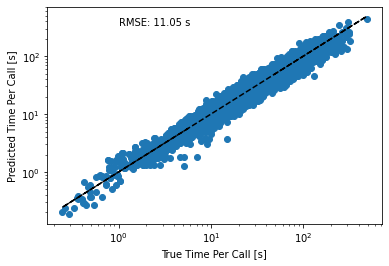

In [5]:
t_hat = Y_hat[:, 0] * X_val['n_el^3']*X_val['n_k']/X_val['n_cores']
t_val = df.loc[ind_val, 'time_per_call']
plt.scatter(t_val, t_hat)
plt.plot(t_val, t_val, 'k--')
target = 'Time Per Call [s]'
rmse = np.mean((t_val.values - t_hat)**2)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e0, 0.7*max((t_val)), "RMSE: %.2f s" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [6]:
model.save("model1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model1/assets


In [8]:
import optimizer as opt

In [24]:
df_ = df.loc[df.arch == 0]
pred_min, true_min, mean_time, time_with_pred_setup = [], [], [], []
pred_tpn, true_tpn, pred_np, true_np = [], [], [], []

for nel in df_.n_el.unique():
    for nn in df_.loc[df_.n_el == nel]['n_nodes'].unique():
        df__ = df_.loc[(df_.n_el == nel) & (df_.n_nodes == nn)]
        time, threads_per_node, n_pool = opt.optimize_from_df("model1", df__.iloc[0])
        true_min.append(df__['time_per_call'].min())
        mean_time.append(df__['time_per_call'].mean())
        minidx = df__['time_per_call'].idxmin()
        time_with_pred_setup.append(df__.loc[(df__.threads_per_node == threads_per_node) & (df__.n_pool == n_pool)]['time_per_call'].mean())
        true_np.append(df__.loc[minidx]['n_pool'])
        true_tpn.append(df__.loc[minidx]['threads_per_node'])
        pred_min.append(time)
        pred_tpn.append(threads_per_node)
        pred_np.append(n_pool)
        
pred_tpn = np.array(pred_tpn)
pred_min = np.array(pred_min)
pred_np = np.array(pred_np)
true_np = np.array(true_np)
true_min = np.array(true_min)
true_tpn = np.array(true_tpn)
mean_time = np.array(mean_time)
time_with_pred_setup = np.array(time_with_pred_setup)

In [25]:
time_with_pred_setup = np.array(time_with_pred_setup)

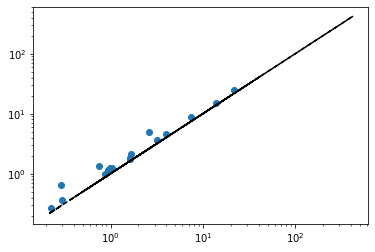

In [34]:
plt.scatter(true_min, time_with_pred_setup)
plt.plot(true_min, true_min, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()

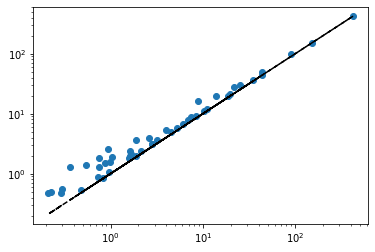

In [35]:
plt.scatter(true_min, mean_time)
plt.plot(true_min, true_min, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()

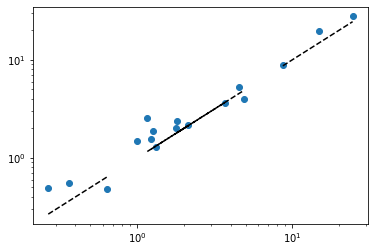

In [36]:
plt.scatter(time_with_pred_setup, mean_time)
plt.plot(time_with_pred_setup, time_with_pred_setup, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()